In [1]:
# =============================================================================
# CONFIGURATION: SET NUMBER OF COMPANIES FOR ANALYSIS
# =============================================================================

# Set the number of companies to analyze
# Options:
#   - Integer (e.g., 100, 1000): Randomly sample this many companies
#   - None: Use all available companies
N_FIRMS = 800

# Seed for reproducibility (only used if N_FIRMS is not None)
RANDOM_SEED = 42

# Set to True to run detailed diagnostics (slow, takes 5-10 minutes)
# Set to False to skip diagnostics and load cached results faster
RUN_DETAILED_DIAGNOSTICS = False

print("="*80)
print("ANALYSIS CONFIGURATION")
print("="*80)
print(f"Number of firms: {'ALL' if N_FIRMS is None else N_FIRMS}")
print(f"Random seed: {RANDOM_SEED if N_FIRMS is not None else 'N/A'}")
print(f"Run detailed diagnostics: {RUN_DETAILED_DIAGNOSTICS}")
print("="*80)

ANALYSIS CONFIGURATION
Number of firms: 800
Random seed: 42
Run detailed diagnostics: False


#Employment Analysis: AI Exposure and Labor Market Dynamics

This notebook analyzes employment trends a variable N of companies from 2021-2025, examining how occupations with different levels of AI exposure evolved around the November 2022 ChatGPT release.

## 📋 Quick Start Guide

**Configuration (see cell above):**
- `N_FIRMS`: Number of companies to analyze (`100`, `1000`, or `None` for ALL)
- `RUN_DETAILED_DIAGNOSTICS`: Set to `False` to skip slow diagnostics (saves 5-10 minutes)

**Output Files** (dynamically named based on N_FIRMS):
- Results: `data/Results/R_{N_FIRMS}_EU_occupation.parquet`
- Plots: `Thesis/Part 4/Images/R_{N_FIRMS}_EU_occupation_{occ_code}.pdf`

**Cache Management:**
- Cache location: `data/Results/occupation_panel_cache_EU_FULL.parquet`
- Cache is shared across all N_FIRMS settings
- Delete cache file to rebuild from scratch (e.g., after data updates)


## 1. Setup: Load Libraries

**Objective**: Import required Python packages for data analysis and visualization.

**Key Libraries**:
- `pandas`: Data manipulation
- `numpy`: Numerical operations
- `statsmodels`: PPML regression (Poisson GLM)
- `matplotlib`: Plotting
- `tqdm`: Progress bars


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm.auto import tqdm
tqdm.pandas()

# Get the directory where the current notebook lives
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # works inside Jupyter

## 2. Load Employment Data

**Objective**: Load employment records and clean data.

**Process**:
1. Load individual position records from parquet file
2. Validate FTE weights (default to 1.0 if missing)
3. Remove positions with missing O*NET occupation codes
4. Report data quality metrics

**Data Structure**:
- Unit of observation: Individual employee position
- Key variables: `rcid` (firm), `onet_code` (occupation), `seniority`, `startdate`, `enddate`, `weight` (FTE)


In [3]:
# Load company individual positions data
company_df = pd.read_parquet(os.path.join(notebook_dir,"..","..","ignored", "EU_USA_data", "EU_large_companies.parquet"))

print(f"Total rows in company data: {len(company_df)}")

#Weight hygiene (FTE weights)
if "weight" not in company_df.columns:
    print("WARNING: 'weight' column not found. Defaulting to weight=1.0 for all rows.")
    company_df["weight"] = 1.0

company_df["weight"] = pd.to_numeric(company_df["weight"], errors="coerce")
n_missing_w = company_df["weight"].isna().sum()
if n_missing_w > 0:
    print(f"WARNING: 'weight' has {n_missing_w:,} missing values. Filling with 1.0.")
    company_df["weight"] = company_df["weight"].fillna(1.0)

# Guard against negative weights (should not happen)
neg_w = (company_df["weight"] < 0).sum()
if neg_w > 0:
    raise ValueError(f"Found {neg_w:,} negative weights. Fix upstream before running PPML.")

# Count and report positions with missing onet_code before dropping
missing_onet_code_count = company_df['onet_code'].isna().sum()
missing_onet_code_pct = (missing_onet_code_count / len(company_df)) * 100
print(f"Positions dropped due to missing onet_code: {missing_onet_code_count}")
print(f"Percentage of dataset dropped: {missing_onet_code_pct:.2f}%")

company_df = company_df.dropna(subset=["onet_code"]).copy()

Total rows in company data: 21369981
Positions dropped due to missing onet_code: 2838
Percentage of dataset dropped: 0.01%


## 3. Detailed Employment Diagnostics (Optional)

**Objective**: Verify data quality and company-level employment patterns before building the occupation panel.

**What This Does**:
- Computes monthly employment for each company across all 58 months (2021-2025)
- Checks for companies with insufficient data (<10 FTE in any month)
- Analyzes employment patterns separately by seniority level

**Performance Note**: 
- ⚠️ **This cell is SLOW** (5-10 minutes) because it loops through every month for every company
- Set `RUN_DETAILED_DIAGNOSTICS = False` in the configuration cell to skip
- These diagnostics are **optional** - the main analysis works without them

In [4]:
# =============================================================================
# OPTIONAL: DETAILED EMPLOYMENT DIAGNOSTICS (SLOW - 5-10 minutes)
# =============================================================================
# This cell performs comprehensive diagnostics by computing monthly employment
# for every company across all months. Skip if you just want to run the analysis.

if RUN_DETAILED_DIAGNOSTICS:
    print("="*80)
    print("RUNNING DETAILED DIAGNOSTICS (this will take 5-10 minutes)")
    print("="*80)
    
    # Diagnostic: Check employment by company and month (FTE-weighted)
    # Calculate monthly employment directly from raw data

    company_df['startdate'] = pd.to_datetime(company_df['startdate'])
    company_df['enddate'] = pd.to_datetime(company_df['enddate'])

    # Define month range
    first_month = pd.Timestamp('2021-01-01')
    last_month = pd.Timestamp('2025-10-01')
    months = pd.date_range(start=first_month, end=last_month, freq='MS')

    company_monthly_df = []
    for month in tqdm(months, desc="Employment by firm-month", total=len(months)):
        active = company_df[
            (company_df['startdate'] <= month) &
            ((company_df['enddate'].isna()) | (company_df['enddate'] >= month))
        ]
        monthly_emp = active.groupby('rcid')["weight"].sum().reset_index(name='employment')
        monthly_emp['month'] = month
        company_monthly_df.append(monthly_emp)

    company_monthly_df = pd.concat(company_monthly_df, ignore_index=True)

    # Summary statistics by company
    print("="*80)
    print("COMPANY EMPLOYMENT DIAGNOSTICS (2021-01 to 2025-10) [FTE-weighted]")
    print("="*80)

    company_stats = company_monthly_df.groupby('rcid').agg({
        'employment': ['min', 'mean', 'max', 'std']
    }).round(2)

    company_stats.columns = ['Min_Monthly', 'Mean_Monthly', 'Max_Monthly', 'Std_Monthly']

    # Add count of months with zero employment
    zero_months = company_monthly_df[company_monthly_df['employment'] == 0].groupby('rcid').size()
    company_stats['Months_Zero'] = zero_months
    company_stats['Months_Zero'] = company_stats['Months_Zero'].fillna(0).astype(int)

    # Add total months
    company_stats['Total_Months'] = company_monthly_df.groupby('rcid').size()

    # Flag companies that fail Brynjolfsson restrictions (min < 10)
    company_stats['Fails_Min10'] = (company_stats['Min_Monthly'] < 10).astype(int)

    print(f"\nTotal companies: {len(company_stats)}")
    print(f"Companies with min employment < 10: {company_stats['Fails_Min10'].sum()}")
    print(f"Companies with any zero-employment months: {(company_stats['Months_Zero'] > 0).sum()}")

    print(f"\n{company_stats}")

    # Check by seniority level
    print("\n" + "="*80)
    print("SENIORITY-SPECIFIC DIAGNOSTICS [FTE-weighted]")
    print("="*80)

    for seniority in tqdm(range(1, 7), desc="Seniority diagnostics", total=6):
        seniority_monthly_df = []
        for month in tqdm(months, desc=f"Sen {seniority}: months", total=len(months), leave=False):
            active = company_df[
                (company_df['startdate'] <= month) &
                ((company_df['enddate'].isna()) | (company_df['enddate'] >= month)) &
                (company_df['seniority'] == seniority)
            ]
            monthly_emp = active.groupby('rcid')["weight"].sum().reset_index(name='employment')
            monthly_emp['month'] = month
            seniority_monthly_df.append(monthly_emp)

        seniority_monthly_df = pd.concat(seniority_monthly_df, ignore_index=True)
        
        # Stats
        min_employment = seniority_monthly_df.groupby('rcid')['employment'].min()
        companies_with_min10 = (min_employment >= 10).sum()
        total_companies = len(min_employment)
        
        print(f"\nSeniority {seniority}:")
        print(f"  Companies with ≥10 FTE every month: {companies_with_min10} / {total_companies}")
        print(f"  Average min monthly FTE: {min_employment.mean():.1f}")
        print(f"  Companies with zero months: {(min_employment == 0).sum()}")

    print("\n" + "="*80)
else:
    print("="*80)
    print("SKIPPING DETAILED DIAGNOSTICS (set RUN_DETAILED_DIAGNOSTICS=True to enable)")
    print("="*80)
    print("This saves 5-10 minutes of computation time.")

SKIPPING DETAILED DIAGNOSTICS (set RUN_DETAILED_DIAGNOSTICS=True to enable)
This saves 5-10 minutes of computation time.


In [5]:
# Check the seniority levels in the data
print("Unique seniority levels:")
print(sorted(company_df['seniority'].unique()))
print(f"\nSeniority value counts:")
print(company_df['seniority'].value_counts().sort_index())

Unique seniority levels:
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Seniority value counts:
seniority
1    6200121
2    6227686
3    3173516
4    3028946
5    2228598
6     445715
7      62561
Name: count, dtype: Int64


## 4. Total Employment Visualization (Optional)

**Objective**: Plot aggregate employment across all Dow Jones firms over time.

**What This Shows**:
- Total FTE headcount summed across all firms and seniority levels
- Overall labor market trends from 2021-2025
- Peak employment periods and current workforce size

**Note**: ⚠️ **This visualization is optional**
- Requires `RUN_DETAILED_DIAGNOSTICS = True`
- Depends on `company_monthly_df` computed in the diagnostics cell
- Helps contextualize whether observed patterns are driven by general hiring/firing or occupation-specific dynamics

In [6]:
# =============================================================================
# OPTIONAL: Total Company FTE Visualization
# =============================================================================
# Requires: RUN_DETAILED_DIAGNOSTICS = True (to generate company_monthly_df)

if RUN_DETAILED_DIAGNOSTICS and 'company_monthly_df' in locals():
    # Total FTE headcount across all firms and seniority levels
    monthly_total = company_monthly_df.groupby('month')['employment'].sum().reset_index()
    monthly_total.columns = ['month', 'total_employees']

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(monthly_total['month'], monthly_total['total_employees'],
            linewidth=2, color='#2E5C8A', marker='o', markersize=3)

    ax.set_title('Total Company FTE Over Time (All Seniority Levels)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('FTE (Weighted Headcount)', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Format x-axis
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

    print(f"\nSummary Statistics:")
    print(f"Peak FTE: {monthly_total['total_employees'].max():,.2f} in {monthly_total.loc[monthly_total['total_employees'].idxmax(), 'month'].strftime('%B %Y')}")

    # Jan 2021
    jan_2021 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2021-01-01'), 'total_employees']
    if not jan_2021.empty:
        print(f"Starting FTE (Jan 2021): {jan_2021.iloc[0]:,.2f}")

    # Oct 2025
    oct_2025 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2025-10-01'), 'total_employees']
    if not oct_2025.empty:
        print(f"Current FTE (Oct 2025): {oct_2025.iloc[0]:,.2f}")

    display(monthly_total)
else:
    print("="*80)
    print("SKIPPING Total Company FTE Visualization")
    print("="*80)
    print("Set RUN_DETAILED_DIAGNOSTICS=True to enable this visualization.")

SKIPPING Total Company FTE Visualization
Set RUN_DETAILED_DIAGNOSTICS=True to enable this visualization.


## 5. Employment by Seniority Level - 6 Subplots (Optional)

**Objective**: Visualize employment trends separately for each of the 6 seniority levels.

**Seniority Structure**:
- Level 1: Early Career 1 
- Level 2: Early Career 2
- Level 3: Developing
- Level 4: Mid-Career 1
- Level 5: Mid-Career 2
- Level 6: Senior

**Note**: ⚠️ **This visualization is optional**
- Requires `RUN_DETAILED_DIAGNOSTICS = True`
- Shows how each career stage evolved over time
- Useful for understanding workforce composition changes

In [7]:
# =============================================================================
# OPTIONAL: Employment by Seniority Level (6 Subplots)
# =============================================================================
# Requires: RUN_DETAILED_DIAGNOSTICS = True (to generate necessary data)

if RUN_DETAILED_DIAGNOSTICS and 'months' in locals() and 'company_df' in locals():
    # Calculate FTE by seniority and month
    seniority_labels = {
        1: 'Early Career 1 (22-25)',
        2: 'Early Career 2 (26-30)',
        3: 'Developing (31-34)',
        4: 'Mid-Career 1 (35-40)',
        5: 'Mid-Career 2 (41-49)',
        6: 'Senior (50+)'
    }

    # Calculate monthly FTE by seniority
    seniority_monthly = []
    for month in months:
        active = company_df[
            (company_df['startdate'] <= month) & 
            ((company_df['enddate'].isna()) | (company_df['enddate'] >= month))
        ]
        monthly_by_sen = active.groupby('seniority')["weight"].sum().reset_index(name='employment')
        monthly_by_sen['month'] = month
        seniority_monthly.append(monthly_by_sen)

    seniority_monthly = pd.concat(seniority_monthly, ignore_index=True)

    # Create 6 subplots (2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Colors for each seniority
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for idx, seniority in enumerate(range(1, 7)):
        ax = axes[idx]
        
        # Filter data for this seniority
        sen_data = seniority_monthly[seniority_monthly['seniority'] == seniority].sort_values('month')
        
        # Plot
        ax.plot(sen_data['month'], sen_data['employment'], 
                linewidth=2.5, color=colors[idx], marker='o', markersize=3)
        
        # Formatting
        ax.set_title(f'{seniority_labels[seniority]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('FTE (Weighted Headcount)', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.tick_params(axis='x', rotation=45)
        
        # Format y-axis with commas
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.2f}'))

    fig.suptitle('FTE Over Time by Seniority Level', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print("\nFTE statistics by seniority level:")
    print("="*80)
    for seniority in range(1, 7):
        sen_data = seniority_monthly[seniority_monthly['seniority'] == seniority]
        print(f"\n{seniority_labels[seniority]}:")
        print(f"  Jan 2021: {sen_data[sen_data['month'] == pd.Timestamp('2021-01-01')]['employment'].values[0]:,.2f}")
        print(f"  Oct 2025: {sen_data[sen_data['month'] == pd.Timestamp('2025-10-01')]['employment'].values[0]:,.2f}")
        print(f"  Peak: {sen_data['employment'].max():,.2f}")
        print(f"  Change: {((sen_data[sen_data['month'] == pd.Timestamp('2025-10-01')]['employment'].values[0] / sen_data[sen_data['month'] == pd.Timestamp('2021-01-01')]['employment'].values[0]) - 1) * 100:.1f}%")
else:
    print("="*80)
    print("SKIPPING Employment by Seniority Level Visualization")
    print("="*80)
    print("Set RUN_DETAILED_DIAGNOSTICS=True to enable this visualization.")

SKIPPING Employment by Seniority Level Visualization
Set RUN_DETAILED_DIAGNOSTICS=True to enable this visualization.


## 6. Load Cached Occupation Panel (if available)

**Objective**: Check if pre-computed occupation panel exists to skip expensive construction.

**Caching Strategy**:
- **First run**: Builds full panel from scratch and saves to cache (~10-15 minutes)
- **Subsequent runs**: Loads from cache instantly (~1 second)
- **Cache location**: `data/Results/occupation_panel_cache_FULL.parquet`

**What's Cached**:
- Complete firm × occupation × seniority × month panel
- All employment events processed using hire/separation logic
- Cumulative employment stocks calculated
- Firm totals computed
- Ready for N_FIRMS filtering (applied in next cell)

**When to Invalidate Cache**: Delete the parquet file if you update the base employment data.


In [8]:
# =============================================================================
# LOAD CACHED OCCUPATION PANEL (if available)
# =============================================================================

cache_dir = os.path.join(notebook_dir, "..", "..", "data", "Results")
cache_file = os.path.join(cache_dir, "occupation_panel_cache_EU_FULL.parquet")

SKIP_CONSTRUCTION = False  # Set to True to force rebuild

if os.path.exists(cache_file) and not SKIP_CONSTRUCTION:
    print("="*80)
    print("LOADING CACHED OCCUPATION PANEL")
    print("="*80)
    print(f"Cache file: {cache_file}")
    
    occupation_panel_full = pd.read_parquet(cache_file)
    
    print(f"✓ Loaded from cache")
    print(f"  Total observations: {len(occupation_panel_full):,}")
    print(f"  Firms: {occupation_panel_full['rcid'].nunique()}")
    print(f"  Occupations: {occupation_panel_full['onet_code'].nunique()}")
    print(f"  Seniority levels: {occupation_panel_full['seniority'].nunique()}")
    print(f"  Months: {occupation_panel_full['month'].nunique()}")
    print(f"  Mean FTE per cell: {occupation_panel_full['employment'].mean():.2f}")
    print("="*80)
    
else:
    print("="*80)
    print("NO CACHE FOUND - WILL BUILD OCCUPATION PANEL FROM SCRATCH")
    print("="*80)
    print("This will take 10-15 minutes on first run.")
    print("The panel will be cached for future runs.")
    occupation_panel_full = None  # Will be built in next cell

LOADING CACHED OCCUPATION PANEL
Cache file: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 4/../../data/Results/occupation_panel_cache_EU_FULL.parquet
✓ Loaded from cache
  Total observations: 64,708,744
  Firms: 2150
  Occupations: 1007
  Seniority levels: 7
  Months: 58
  Mean FTE per cell: 6.84


## 7. Build Occupation Panel (if not cached)

**Objective**: Construct firm × occupation × seniority × month panel with FTE-weighted employment stocks.

**Panel Construction Logic**:
1. **Data Quality Check**: Verify coverage and identify potential data truncation issues
2. **Event-Based Accounting**: Convert hire/separation dates to monthly employment stocks
3. **Month-Start Snapshots**: Align all employment to first day of each month
4. **Cumulative Sum**: Build employment stocks from entry/exit events
5. **Validation**: Cross-check panel totals against direct calculations
6. **Cache**: Save to parquet for instant loading on future runs

**Key Assumptions**:
- Employees are counted if active on the first day of each month
- Missing `enddate` = current employee (still employed)
- FTE weights represent fractional employment (e.g., 0.5 = part-time)

**Sample Restrictions (applied AFTER caching)**:
- Firm filter: Keep firms with ≥10 FTE every month
- Occupation×Seniority filter: Keep pairs with ≥10 total FTE every month (across all firms)
- N_FIRMS filter: Random sample of firms (if specified in configuration)

**Output**: `occupation_panel` with columns:
- `rcid`: Firm identifier
- `onet_code`: O*NET occupation code
- `seniority`: Career stage (1-6)
- `month`: First day of month
- `employment`: FTE stock on that date
- `total_firm_employment`: Total firm FTE (for offset)
- `month_relative`: Months since October 2022 baseline


In [9]:
# ===========================================================================
# BUILD OCCUPATION-LEVEL PANEL WITH OFFSET (OBSERVED GROUPS ONLY, FTE-weighted)
# ===========================================================================

# Skip if already loaded from cache
if occupation_panel_full is not None:
    print("="*80)
    print("SKIPPING CONSTRUCTION - USING CACHED PANEL")
    print("="*80)
    occupation_panel = occupation_panel_full.copy()
else:
    print("="*80)
    print("BUILDING FIRM × OCCUPATION × MONTH PANEL (FTE-weighted)")
    print("="*80)

    company_df_for_occ = company_df[['rcid', 'onet_code', 'startdate', 'enddate', 'seniority', 'weight']].copy()
    company_df_for_occ['weight'] = pd.to_numeric(company_df_for_occ['weight'], errors='coerce').fillna(1.0)
    company_df_for_occ['startdate'] = pd.to_datetime(company_df_for_occ['startdate'])
    company_df_for_occ['enddate'] = pd.to_datetime(company_df_for_occ['enddate'])

    print("\n" + "="*80)
    print("DATA QUALITY CHECK")
    print("="*80)

    total_positions = len(company_df_for_occ)
    missing_enddate = company_df_for_occ['enddate'].isna().sum()
    print(f"Total positions: {total_positions:,}")
    print(f"Positions with missing enddate (current employees): {missing_enddate:,} ({missing_enddate/total_positions*100:.1f}%)")

    first_month = pd.Timestamp('2021-01-01')
    initial_last_month = pd.Timestamp('2025-10-01')
    test_months = pd.date_range(start=first_month, end=initial_last_month, freq='MS')

    employment_by_month = []
    for month in tqdm(test_months[-12:], desc="Diagnostics: last 12 months", total=12):
        active = company_df_for_occ[
            (company_df_for_occ['startdate'] <= month) &
            ((company_df_for_occ['enddate'].isna()) | (company_df_for_occ['enddate'] >= month))
        ]
        employment_by_month.append({'month': month, 'employment': float(active['weight'].sum())})

    emp_df = pd.DataFrame(employment_by_month)
    print(f"\nEmployment in last 12 months (FTE):")
    for _, row in emp_df.iterrows():
        print(f"  {row['month'].strftime('%Y-%m')}: {row['employment']:.2f}")

    recent_6 = emp_df.tail(6)
    peak_recent = recent_6['employment'].max()
    latest = emp_df.iloc[-1]['employment']
    decline_pct = (1 - latest / peak_recent) * 100

    print(f"\nDecline from recent peak: {decline_pct:.1f}%")

    emp_df['employment_change'] = emp_df['employment'].pct_change() * 100
    consecutive_declines = 0
    safe_end_month = emp_df.iloc[-1]['month']

    for i in range(len(emp_df) - 1, 0, -1):
        if emp_df.iloc[i]['employment_change'] < -5:
            consecutive_declines += 1
        else:
            safe_end_month = emp_df.iloc[i]['month']
            break

    if decline_pct > 10 and consecutive_declines >= 2:
        print(f"\nWARNING: Significant decline detected in recent months")
        print(f"Possible causes:")
        print(f"1. Dataset collection ended before Oct 2025 (missing recent hires)")
        print(f"2. Real employment decline in Dow companies")
        print(f"SOLUTION: Truncating analysis to {safe_end_month.strftime('%B %Y')} for data reliability")
        last_month = safe_end_month
    elif decline_pct > 10:
        print(f"\nWARNING: Employment declined {decline_pct:.1f}% in last 6 months")
        print(f"This appears to be a real trend (not a data collection issue)")
        print(f"Keeping full period through Oct 2025 for analysis")
        last_month = pd.Timestamp('2025-10-01')
    else:
        print(f"\nData coverage appears stable (decline only {decline_pct:.1f}%)")
        last_month = pd.Timestamp('2025-10-01')

    baseline_date = pd.Timestamp('2022-10-01')
    months = pd.date_range(start=first_month, end=last_month, freq='MS')

    print(f"\n" + "="*80)
    print("FINAL PARAMETERS")
    print("="*80)
    print(f"Analysis period: {first_month.strftime('%Y-%m')} to {last_month.strftime('%Y-%m')}")
    print(f"Total months: {len(months)}")
    print(f"Baseline (ChatGPT release): {baseline_date.strftime('%Y-%m')}")
    print(f"Firms: {company_df_for_occ['rcid'].nunique()}")
    print(f"Occupations: {company_df_for_occ['onet_code'].nunique()}")

    print(f"\n" + "="*80)
    print("BUILDING PANEL WITH EXPLICIT ZERO EMPLOYMENT CELLS (FTE-weighted)")
    print("="*80)

    # Clean obvious data errors: enddate earlier than startdate
    company_df_for_occ = company_df_for_occ[
        company_df_for_occ['enddate'].isna() | (company_df_for_occ['enddate'] >= company_df_for_occ['startdate'])
    ].copy()

    # Month-start snapshot (ceil start to the next month start if mid-month; month start itself if already aligned)
    company_df_for_occ['start_m'] = company_df_for_occ['startdate'].apply(lambda d: d + pd.offsets.MonthBegin(0))

    # Restrict spells to those that intersect the analysis window in continuous time
    mask_in_window = (
        (company_df_for_occ['start_m'] <= last_month) &
        (company_df_for_occ['enddate'].isna() | (company_df_for_occ['enddate'] >= first_month))
    )
    spells_in_window = company_df_for_occ.loc[
        mask_in_window, ['rcid','onet_code','seniority','start_m','startdate','enddate','weight']
    ].copy()

    print(f"Spells intersecting window (continuous-time): {len(spells_in_window):,} / {len(company_df_for_occ):,}")

    # Critical fix: keep only spells that are active at least once on a month-start snapshot
    spells_in_window['end_m_active'] = spells_in_window['enddate'].dt.to_period('M').dt.to_timestamp()
    spells_in_window.loc[spells_in_window['enddate'].isna(), 'end_m_active'] = last_month

    spells_in_window = spells_in_window[spells_in_window['start_m'] <= spells_in_window['end_m_active']].copy()

    print(f"Spells with month-start support: {len(spells_in_window):,}")

    # Build weighted events
    events_list = []
    last_month_plus_1 = last_month + pd.DateOffset(months=1)

    for row in tqdm(
        spells_in_window.itertuples(index=False),
        total=len(spells_in_window),
        desc="Building hire/separation events (FTE-weighted)"
    ):
        rcid = row.rcid
        onet_code = row.onet_code
        seniority = row.seniority
        start_m = row.start_m
        enddate = row.enddate
        w = float(row.weight)

        entry_month = max(start_m, first_month)
        events_list.append({
            'rcid': rcid,
            'onet_code': onet_code,
            'seniority': seniority,
            'month': entry_month,
            'delta': w
        })

        # Exit event at first month start strictly after enddate
        if pd.notna(enddate):
            exit_month = enddate + pd.offsets.MonthBegin(0)
            if exit_month == enddate:
                exit_month = enddate + pd.offsets.MonthBegin(1)

            # Clip exit events to the cumsum domain
            if (exit_month >= first_month) and (exit_month <= last_month_plus_1):
                events_list.append({
                    'rcid': rcid,
                    'onet_code': onet_code,
                    'seniority': seniority,
                    'month': exit_month,
                    'delta': -w
                })

    # Convert to DataFrame and ensure float
    events_df = pd.DataFrame(events_list)
    events_df['delta'] = pd.to_numeric(events_df['delta'], errors='coerce').fillna(0.0).astype(float)

    print(f"Total events created: {len(events_df):,} (+weight hires and -weight separations)")
    print(f"Entry events clipped to window: first_month={first_month.strftime('%Y-%m')}")
    print(f"Exit events allowed through: last_month+1={last_month_plus_1.strftime('%Y-%m')}")

    event_deltas = (
        events_df
        .groupby(['rcid', 'onet_code', 'seniority', 'month'], as_index=False)['delta']
        .sum()
    )

    print(f"Unique event cells (rcid × onet × sen × month with changes): {len(event_deltas):,}")

    # Build grid only over observed firm×occ×sen groups × months
    groups = spells_in_window[['rcid','onet_code','seniority']].drop_duplicates()
    print(f"Observed firm×occ×sen groups in window (month-start supported): {len(groups):,}")

    month_df = pd.DataFrame({'month': months})
    groups['key'] = 1
    month_df['key'] = 1
    grid = groups.merge(month_df, on='key', how='inner').drop(columns=['key'])

    print(f"Grid size (observed groups × months): {len(grid):,}")

    # Merge deltas, fill missing with 0
    grid = grid.merge(
        event_deltas,
        on=['rcid','onet_code','seniority','month'],
        how='left'
    )
    grid['delta'] = pd.to_numeric(grid['delta'], errors='coerce').fillna(0.0).astype(float)

    # Cumsum to get FTE employment stock
    grid = grid.sort_values(['rcid','onet_code','seniority','month'])
    grid['employment'] = grid.groupby(['rcid','onet_code','seniority'])['delta'].cumsum().astype(float)

    # Guard: negative FTE headcount check (allowing small floating error)
    min_emp = grid.groupby(['rcid','onet_code','seniority'])['employment'].min()
    assert (min_emp >= -1e-9).all(), "Negative weighted headcount detected: event logic inconsistent."
    grid['employment'] = grid['employment'].clip(lower=0.0)

    occupation_panel = grid[['rcid','onet_code','seniority','month','employment']].copy()

    # Add firm totals
    firm_totals = (
        occupation_panel
        .groupby(['rcid', 'month'], as_index=False)['employment']
        .sum()
        .rename(columns={'employment': 'total_firm_employment'})
    )
    occupation_panel = occupation_panel.merge(firm_totals, on=['rcid','month'], how='left')

    # month_relative
    occupation_panel['month_relative'] = (
        (occupation_panel['month'].dt.year - baseline_date.year) * 12 +
        (occupation_panel['month'].dt.month - baseline_date.month)
    )

    print(f"\n" + "="*80)
    print("ACCEPTANCE CHECKS (FTE-weighted)")
    print("="*80)

    zero_cells = (occupation_panel['employment'] == 0).sum()
    total_cells = len(occupation_panel)
    print(f"Zero employment cells: {zero_cells:,} ({zero_cells/total_cells*100:.1f}%)")

    all_zero_groups = (
        occupation_panel
        .groupby(['rcid','onet_code','seniority'])['employment']
        .sum()
        .eq(0)
        .sum()
    )
    print(f"All-zero groups (should be 0): {all_zero_groups}")
    assert all_zero_groups == 0, "Found all-zero groups; grid construction is still including non-existent groups."

    print(f"\nValidation: Initial FTE stock at first_month ({first_month.strftime('%Y-%m')})")
    panel_first_month = occupation_panel.loc[occupation_panel['month'] == first_month, 'employment'].sum()

    direct_first_month = float(company_df_for_occ[
        (company_df_for_occ['startdate'] <= first_month) &
        ((company_df_for_occ['enddate'].isna()) | (company_df_for_occ['enddate'] >= first_month))
    ]['weight'].sum())

    difference = panel_first_month - direct_first_month
    print(f"Panel FTE (first_month): {panel_first_month:,.2f}")
    print(f"Direct FTE (first_month):     {direct_first_month:,.2f}")
    print(f"Difference:                   {difference:,.2f}")

    if abs(difference) < 1e-6:
        print("Perfect match")
    elif abs(difference) <= 10:
        print(f"Small difference ({abs(difference):.2f} FTE)")
    else:
        print(f"WARNING: Large difference detected")

    check_month = months[len(months)//2]
    panel_mid = occupation_panel.loc[occupation_panel['month'] == check_month, 'employment'].sum()
    direct_mid = float(company_df_for_occ[
        (company_df_for_occ['startdate'] <= check_month) &
        ((company_df_for_occ['enddate'].isna()) | (company_df_for_occ['enddate'] >= check_month))
    ]['weight'].sum())

    print(f"\nValidation: Midpoint FTE stock at {check_month.strftime('%Y-%m')}")
    print(f"Panel:  {panel_mid:,.2f}")
    print(f"Direct: {direct_mid:,.2f}")
    assert abs(panel_mid - direct_mid) < 1e-6, "Midpoint FTE stock mismatch: check entry/exit month logic."

    print(f"\n" + "="*80)
    print("OCCUPATION PANEL CREATED (OBSERVED GROUPS ONLY, FTE-weighted)")
    print("="*80)
    # =======================================================================
    # SAVE TO CACHE
    # =======================================================================
    print(f"\n" + "="*80)
    print("SAVING OCCUPATION PANEL TO CACHE")
    print("="*80)
    
    os.makedirs(cache_dir, exist_ok=True)
    occupation_panel.to_parquet(cache_file, index=False)
    
    print(f"✓ Saved to: {cache_file}")
    print(f"  Size: {os.path.getsize(cache_file) / (1024**2):.1f} MB")
    print("  Future runs will load instantly from this cache.")
    print("="*80)
    
    # Store full panel for filtering
    occupation_panel_full = occupation_panel.copy()

# =============================================================================
# APPLY N_FIRMS FILTER FROM CONFIGURATION
# =============================================================================

print(f"\n" + "="*80)
print("APPLYING FIRM FILTER")
print("="*80)

if N_FIRMS is not None:
    print(f"Restricting to random sample of {N_FIRMS} firms")
    
    # Get all unique firms
    all_firms = occupation_panel_full['rcid'].unique()
    
    # Randomly sample N_FIRMS firms
    np.random.seed(RANDOM_SEED)
    random_firms = np.random.choice(all_firms, size=min(N_FIRMS, len(all_firms)), replace=False)

    occupation_panel = occupation_panel_full[
        occupation_panel_full["rcid"].isin(random_firms)
    ].copy()

    print(f"✓ Firms kept: {occupation_panel['rcid'].nunique()} / {len(all_firms)}")
    print(f"✓ Observations kept: {len(occupation_panel):,} / {len(occupation_panel_full):,}")
else:
    print("Using ALL firms (no filtering)")
    occupation_panel = occupation_panel_full.copy()
    print(f"✓ Total firms: {occupation_panel['rcid'].nunique()}")
    print(f"✓ Total observations: {len(occupation_panel):,}")

# Sample restriction 1: Firm-level filter (≥10 FTE every month)
firm_monthly_min = (
    occupation_panel
    .groupby(['rcid','month'], as_index=False)['employment']
    .sum()
    .groupby('rcid')['employment']
    .min()
)
valid_firms = firm_monthly_min[firm_monthly_min >= 10].index.tolist()

print(f"\nSample restriction 1: Firm-level filter (FTE)")
print(f"Firms with ≥10 FTE every month: {len(valid_firms)}/{occupation_panel['rcid'].nunique()}")

occupation_panel = occupation_panel[occupation_panel['rcid'].isin(valid_firms)].copy()

print(f"\nAfter firm-level filter:")
print(f"Firms: {occupation_panel['rcid'].nunique()}")
print(f"Occupations: {occupation_panel['onet_code'].nunique()}")
print(f"Observations: {len(occupation_panel):,}")

# Sample restriction 2: Occupation × Seniority filter (≥10 FTE every month)
print(f"\n" + "="*80)
print("Sample restriction 2: Occupation × Seniority level filter (FTE)")
print("="*80)
print("Requiring each occupation×seniority combination to have ≥10 FTE TOTAL (across all firms) in EVERY month")

occ_sen_monthly_totals = (
    occupation_panel
    .groupby(['onet_code','seniority','month'])['employment']
    .sum()
    .reset_index()
    .rename(columns={'employment': 'total_employment'})
)

occ_sen_min_monthly = (
    occ_sen_monthly_totals
    .groupby(['onet_code','seniority'])['total_employment']
    .min()
    .reset_index()
    .rename(columns={'total_employment': 'min_monthly_employment'})
)

MIN_MONTHLY_EMPLOYMENT = 10
valid_occ_sen_pairs = occ_sen_min_monthly.loc[
    occ_sen_min_monthly['min_monthly_employment'] >= MIN_MONTHLY_EMPLOYMENT,
    ['onet_code','seniority']
]
print(f"Occupation×Seniority pairs: {len(occupation_panel.groupby(['onet_code','seniority']))}")
print(f"\nOccupation×Seniority pairs before filter: {len(occupation_panel.groupby(['onet_code','seniority']))}")
# Initial diagnostics
print("=" * 80)
print(f"Median FTE per cell: {occupation_panel['employment'].median():.2f}")
print(f"Mean FTE per cell: {occupation_panel['employment'].mean():.2f}")
print(f"Month range: {occupation_panel['month_relative'].min()} to {occupation_panel['month_relative'].max()}")
print(f"Observations: {len(occupation_panel):,}")
print(f"Occupation×Seniority pairs: {occupation_panel.groupby(['onet_code', 'seniority']).ngroups}")
print(f"Occupations: {occupation_panel['onet_code'].nunique()}")
print(f"Firms: {occupation_panel['rcid'].nunique()}")

# Filter occupation × seniority pairs
print("\nAfter occupation×seniority filter:")

occupation_panel = (
    occupation_panel
    .merge(
        valid_occ_sen_pairs,
        how="inner",
        on=["onet_code", "seniority"]
    )
    .copy()
)

# Post-filter diagnostics
print(f"Occupation×Seniority pairs after filter (≥{MIN_MONTHLY_EMPLOYMENT} FTE every month): "
      f"{valid_occ_sen_pairs.shape[0]}")
print(f"Month range: {occupation_panel['month_relative'].min()} to {occupation_panel['month_relative'].max()}")
print(f"Mean FTE per cell: {occupation_panel['employment'].mean():.2f}")
print(f"Median FTE per cell: {occupation_panel['employment'].median():.2f}")

print("=" * 80)

# Preview
occupation_panel.head(10)

SKIPPING CONSTRUCTION - USING CACHED PANEL

APPLYING FIRM FILTER
Restricting to random sample of 800 firms
✓ Firms kept: 800 / 2150
✓ Observations kept: 23,332,414 / 64,708,744

Sample restriction 1: Firm-level filter (FTE)
Firms with ≥10 FTE every month: 799/800

After firm-level filter:
Firms: 799
Occupations: 1000
Observations: 23,322,438

Sample restriction 2: Occupation × Seniority level filter (FTE)
Requiring each occupation×seniority combination to have ≥10 FTE TOTAL (across all firms) in EVERY month
Occupation×Seniority pairs: 5617

Occupation×Seniority pairs before filter: 5617
Median FTE per cell: 1.34
Mean FTE per cell: 6.98
Month range: -21 to 36
Observations: 23,322,438
Occupation×Seniority pairs: 5617
Occupations: 1000
Firms: 799

After occupation×seniority filter:
Occupation×Seniority pairs after filter (≥10 FTE every month): 3364
Month range: -21 to 36
Mean FTE per cell: 7.16
Median FTE per cell: 1.36


,rcid,onet_code,seniority,month,employment,total_firm_employment,month_relative
0,923.0,11-1011.00,3,2021-01-01,1.278502,905.240767,-21
1,923.0,11-1011.00,3,2021-02-01,1.278502,887.998120,-20
2,923.0,11-1011.00,3,2021-03-01,1.278502,902.795144,-19
3,923.0,11-1011.00,3,2021-04-01,1.278502,887.063749,-18
4,923.0,11-1011.00,3,2021-05-01,1.278502,894.018244,-17
5,923.0,11-1011.00,3,2021-06-01,1.278502,904.767414,-16
6,923.0,11-1011.00,3,2021-07-01,1.278502,891.655638,-15
7,923.0,11-1011.00,3,2021-08-01,1.278502,889.715441,-14
8,923.0,11-1011.00,3,2021-09-01,1.278502,888.546407,-13
9,923.0,11-1011.00,3,2021-10-01,1.278502,901.101779,-12


## 8. Estimate Occupation×Seniority PPML Regressions

**Objective**: Run separate Poisson regressions for each occupation×seniority pair to estimate event-time coefficients measuring within-firm reallocation.

**Econometric Model** (estimated separately for each occupation $o$ × seniority $s$ pair):

$$\log \mathbb{E}[y_{f,o,s,t}] = \beta \log Y_{f,t} + \alpha_{f,o,s} + \sum_{k \neq -1} \delta_{o,s,k} \cdot \mathbb{1}\{t = k\}$$

**Where**:
- $y_{f,o,s,t}$ = FTE employment in firm $f$, occupation $o$, seniority $s$, month $t$
- $Y_{f,t}$ = total firm employment (included as offset with $\beta=1$ fixed by construction)
- $\alpha_{f,o,s}$ = firm-occupation-seniority fixed effects (time-invariant staffing levels)
- $\delta_{o,s,k}$ = event-time coefficients (occupation-seniority reallocation in month $k$)
- Reference period: September 2022 ($k=-1$, month before ChatGPT release)

**Why Separate Regressions?**
- Each occupation×seniority pair gets its own set of event-time coefficients
- Allows heterogeneous effects across both occupations AND career stages
- Prevents seasonality patterns from bleeding between seniority levels

**Fixed Effects Control For**:
- Baseline firm-occupation-seniority staffing patterns (e.g., CompanyX hires more senior engineers)
- Time-invariant unobserved heterogeneity

**Interpretation**: $\delta_{o,s,k}$ captures how occupation $o$ at seniority $s$ changes its share of firm employment in month $k$ relative to September 2022, conditional on baseline staffing patterns.

**Output**: Dictionary mapping `(onet_code, seniority)` → regression results with coefficients, standard errors, and diagnostics


In [10]:
# ============================================================================
# RUN OCCUPATION-LEVEL PPML REGRESSIONS
# Fix: force fully numeric exog/endog/offset (avoids "cast to numpy dtype of object")
# ============================================================================

print("=" * 80)
print("ESTIMATING OCCUPATION-LEVEL POISSON REGRESSIONS")
print("=" * 80)
print("Using statsmodels GLM with fixed offset (coefficient on log_firm_size fixed to 1.0 by construction; no elasticity estimated)")

# ---------------------------------------------------------------------------
# DIAGNOSTICS: occupation_panel exists
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("DIAGNOSTIC: OCCUPATION PANEL STATUS")
print("=" * 80)

if 'occupation_panel' not in locals():
    raise RuntimeError("occupation_panel not found. Run the panel construction cell first.")

print("✓ occupation_panel exists")
print(f"  Total rows: {len(occupation_panel):,}")
print(f"  Unique firms: {occupation_panel['rcid'].nunique()}")
print(f"  Unique occupations: {occupation_panel['onet_code'].nunique()}")
print(f"  Unique months: {occupation_panel['month'].nunique()}")
print("\n  Sample of occupation codes:")
print(f"  {list(occupation_panel['onet_code'].unique()[:10])}")

# Ensure core numeric columns are numeric
occupation_panel = occupation_panel.copy()
occupation_panel['employment'] = pd.to_numeric(occupation_panel['employment'], errors='coerce')
occupation_panel['total_firm_employment'] = pd.to_numeric(occupation_panel['total_firm_employment'], errors='coerce')

# Offset
occupation_panel['log_offset'] = np.log(occupation_panel['total_firm_employment'])

# Hard guards
bad = occupation_panel['employment'].isna().sum()
if bad > 0:
    print(f"\nWARNING: employment has {bad} NaNs after coercion; dropping those rows")
    occupation_panel = occupation_panel.dropna(subset=['employment']).copy()

bad_off = (~np.isfinite(occupation_panel['log_offset'])).sum()
if bad_off > 0:
    print(f"\nWARNING: log_offset has {bad_off} non-finite values; dropping those rows")
    occupation_panel = occupation_panel[np.isfinite(occupation_panel['log_offset'])].copy()

assert (occupation_panel['total_firm_employment'] >= 10).all(), "Offset invalid: total firm employment must be ≥10."

# ---------------------------------------------------------------------------
# Sample sizes
# ---------------------------------------------------------------------------
occ_sen_counts = occupation_panel.groupby(['onet_code', 'seniority']).size()

print("\n" + "=" * 80)
print("DIAGNOSTIC: OCCUPATION × SENIORITY SAMPLE SIZES")
print("=" * 80)
print(f"Total unique occupation×seniority pairs: {len(occ_sen_counts)}")
print("\nDistribution of observation counts:")
print(occ_sen_counts.describe())
print("\nOccupation×Seniority pairs by sample size threshold:")
print(f"  ≥50 obs:  {(occ_sen_counts >= 50).sum()}")
print(f"  ≥100 obs: {(occ_sen_counts >= 100).sum()}")
print(f"  ≥200 obs: {(occ_sen_counts >= 200).sum()}")
print(f"  ≥500 obs: {(occ_sen_counts >= 500).sum()}")

print("\nTop 10 occupation×seniority pairs by observation count:")
top_pairs = occ_sen_counts.sort_values(ascending=False).head(10)
for (occ, sen), count in top_pairs.items():
    print(f"  {occ} × Seniority {sen}: {count:,} observations")

pairs_to_analyze = occ_sen_counts[occ_sen_counts >= 100].index.tolist()

print("\n" + "=" * 80)
print("REGRESSION ESTIMATION SETUP")
print("=" * 80)
print(f"Occupation×Seniority pairs meeting ≥100 obs threshold: {len(pairs_to_analyze)}")
print(f"Total unique pairs in data: {len(occ_sen_counts)}")

if len(pairs_to_analyze) == 0:
    print("\nWARNING: No pairs meet the 100 observation threshold; falling back to ≥50")
    pairs_to_analyze = occ_sen_counts[occ_sen_counts >= 50].index.tolist()
    print(f"Pairs with ≥50 observations: {len(pairs_to_analyze)}")

# Event-time configuration
months_rel = sorted(occupation_panel['month_relative'].unique())
reference_month = -1  # Sept 2022
baseline_date = pd.Timestamp('2022-10-01')

print(f"\nEvent-time range: {min(months_rel)} to {max(months_rel)} months")
print(f"Reference month: {reference_month} (Sept 2022)")
print(f"\nEstimating regressions for {len(pairs_to_analyze)} occupation×seniority pairs...")

# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
def _build_event_term_name(m):
    return f"Mn{abs(m)}" if m < 0 else f"Mp{m}"

# Precompute all event terms (excluding reference)
all_event_terms = [_build_event_term_name(m) for m in months_rel if m != reference_month]
month_to_term = {m: _build_event_term_name(m) for m in months_rel if m != reference_month}

def run_one_pair(occ_code, seniority, debug=False):
    occ_data = occupation_panel[
        (occupation_panel['onet_code'] == occ_code) &
        (occupation_panel['seniority'] == seniority)
    ].copy()

    if debug:
        print(f"    Data filtered: {len(occ_data)} rows")
        print(f"    Unique firms: {occ_data['rcid'].nunique()}")
        print(f"    Unique months: {occ_data['month_relative'].nunique()}")

    if len(occ_data) == 0:
        raise ValueError("No data after filtering")

    # Drop months where this occupation×seniority has zero total employment across the sample
    month_totals = occ_data.groupby('month_relative')['employment'].sum()
    zero_months = month_totals[month_totals == 0].index.tolist()
    if len(zero_months) > 0:
        occ_data = occ_data[~occ_data['month_relative'].isin(zero_months)].copy()

    # FE id
    occ_data['firm_occ_sen'] = (
        occ_data['rcid'].astype(str) + '_' +
        occ_data['onet_code'].astype(str) + '_' +
        occ_data['seniority'].astype(str)
    )

    # Event-time dummies (only for months present in occ_data)
    present_months = sorted(occ_data['month_relative'].unique())
    present_months = [m for m in present_months if m != reference_month]

    event_cols = []
    event_mat = {}
    for m in present_months:
        col = month_to_term.get(m, None)
        if col is None:
            continue
        event_mat[col] = (occ_data['month_relative'] == m).astype(np.int8)
        event_cols.append(col)

    if len(event_cols) == 0:
        raise ValueError("No event-time variation after dropping zero months / reference month")

    dummy_df = pd.DataFrame(event_mat, index=occ_data.index)

    # FE dummies (drop first)
    fe_dummies = pd.get_dummies(occ_data['firm_occ_sen'], prefix='fe', drop_first=True)

    # Assemble X
    X = pd.concat([dummy_df, fe_dummies], axis=1)
    X = sm.add_constant(X, has_constant="add")

    # Force numeric matrices (this is the core fix)
    X = X.apply(pd.to_numeric, errors='coerce')
    if X.isna().any().any():
        X = X.fillna(0)

    X = X.astype(np.float64)

    y = pd.to_numeric(occ_data['employment'], errors='coerce').astype(np.float64)
    offset = pd.to_numeric(occ_data['log_offset'], errors='coerce').astype(np.float64)

    # Finite guards
    ok = np.isfinite(y) & np.isfinite(offset) & np.all(np.isfinite(X.to_numpy()), axis=1)
    if ok.sum() != len(occ_data):
        occ_data = occ_data.loc[ok].copy()
        y = y[ok]
        offset = offset[ok]
        X = X.loc[ok].copy()

    # Fit
    colnames = X.columns
    model = sm.GLM(y.to_numpy(), X.to_numpy(), family=sm.families.Poisson(), offset=offset.to_numpy())
    result = model.fit(maxiter=200, disp=0)

    # Wrap params/se back into labeled Series for downstream code compatibility
    coefs = pd.Series(result.params, index=colnames)
    ses = pd.Series(result.bse, index=colnames)

    # Summary stats for your downstream table
    post_terms = [c for c in coefs.index if c.startswith('Mp')]
    last_period = None
    if post_terms:
        last_period = max(int(t[2:]) for t in post_terms)

    last_period_name = f"Mp{last_period}" if last_period is not None else None
    last_period_coef = float(coefs.get(last_period_name, np.nan)) if last_period_name else np.nan
    last_period_se = float(ses.get(last_period_name, np.nan)) if last_period_name else np.nan

    avg_post_effect = np.nan
    if post_terms:
        avg_post_effect = float(np.nanmean([coefs.get(t, np.nan) for t in post_terms]))

    # Track dropped event dummies (expected in full timeline, missing here)
    expected_event_terms = set(all_event_terms)
    estimated_terms = set([c for c in coefs.index if c.startswith('Mp') or c.startswith('Mn')])
    dropped_event_months = sorted(list(expected_event_terms - estimated_terms))

    return {
        'result': result,
        'model': result,
        'coefs': coefs,
        'se': ses,
        'n_obs': int(len(occ_data)),
        'n_firms': int(occ_data['rcid'].nunique()),
        'last_period_coef': last_period_coef,
        'last_period_se': last_period_se,
        'avg_post_effect': avg_post_effect,
        'dropped_event_months': dropped_event_months,
    }

# ---------------------------------------------------------------------------
# Run all pairs
# ---------------------------------------------------------------------------
occupation_results = {}
failed_occupations = []
failure_reasons = {}
non_converged_models = []

for idx, (occ_code, seniority) in enumerate(
    tqdm(pairs_to_analyze, desc="PPML: occ×sen regressions", total=len(pairs_to_analyze)),
    1
):
    if idx % 50 == 0:
        print(f"  Progress: {idx}/{len(pairs_to_analyze)} pairs completed")

    debug = idx <= 3
    if debug:
        print(f"\n  Attempting pair {idx}: {occ_code} × Seniority {seniority}")

    try:
        res = run_one_pair(occ_code, seniority, debug=debug)

        # statsmodels GLM usually converges; keep a separate flag just in case
        if hasattr(res['result'], "converged") and (not res['result'].converged):
            non_converged_models.append((occ_code, seniority))
            if debug:
                print("    WARNING: Model did not converge")
            continue

        occupation_results[(occ_code, seniority)] = res

    except Exception as e:
        failed_occupations.append((occ_code, seniority))
        failure_reasons[(occ_code, seniority)] = str(e)
        if debug:
            print(f"    ERROR: {e}")

# ---------------------------------------------------------------------------
# Summary
# ---------------------------------------------------------------------------
print("\n" + "=" * 80)
print("ESTIMATION SUMMARY")
print("=" * 80)
print(f"Total pairs attempted: {len(pairs_to_analyze)}")
print(f"  Successful estimations: {len(occupation_results)}")
print(f"  Non-converged models: {len(non_converged_models)}")
print(f"  Estimation failures (exceptions): {len(failed_occupations)}")

if len(non_converged_models) > 0:
    print(f"\nFirst 10 non-converged pairs:")
    for occ_code, seniority in non_converged_models[:10]:
        print(f"  {occ_code} × Seniority {seniority}")

if len(failed_occupations) > 0:
    print(f"\nFirst 10 estimation failures:")
    for occ_code, seniority in failed_occupations[:10]:
        print(f"  {occ_code} × Seniority {seniority}: {failure_reasons.get((occ_code, seniority), '')}")


ESTIMATING OCCUPATION-LEVEL POISSON REGRESSIONS
Using statsmodels GLM with fixed offset (coefficient on log_firm_size fixed to 1.0 by construction; no elasticity estimated)

DIAGNOSTIC: OCCUPATION PANEL STATUS
✓ occupation_panel exists
  Total rows: 22,635,428
  Unique firms: 799
  Unique occupations: 810
  Unique months: 58

  Sample of occupation codes:
  ['11-1011.00', '11-1021.00', '11-2011.00', '11-2021.00', '11-2022.00', '11-3012.00', '11-3013.00', '11-3013.01', '11-3021.00', '11-3031.00']

DIAGNOSTIC: OCCUPATION × SENIORITY SAMPLE SIZES
Total unique occupation×seniority pairs: 3364

Distribution of observation counts:
count     3364.000000
mean      6728.724138
std       7759.557850
min         58.000000
25%       1566.000000
50%       3480.000000
75%       8816.000000
max      41470.000000
dtype: float64

Occupation×Seniority pairs by sample size threshold:
  ≥50 obs:  3364
  ≥100 obs: 3363
  ≥200 obs: 3358
  ≥500 obs: 3306

Top 10 occupation×seniority pairs by observation coun

PPML: occ×sen regressions:   0%|          | 0/3363 [00:00<?, ?it/s]


  Attempting pair 1: 11-1011.00 × Seniority 1
    Data filtered: 10904 rows
    Unique firms: 188
    Unique months: 58

  Attempting pair 2: 11-1011.00 × Seniority 2
    Data filtered: 15138 rows
    Unique firms: 261
    Unique months: 58

  Attempting pair 3: 11-1011.00 × Seniority 3
    Data filtered: 15834 rows
    Unique firms: 273
    Unique months: 58
  Progress: 50/3363 pairs completed
  Progress: 100/3363 pairs completed
  Progress: 150/3363 pairs completed
  Progress: 200/3363 pairs completed
  Progress: 250/3363 pairs completed
  Progress: 300/3363 pairs completed
  Progress: 350/3363 pairs completed
  Progress: 400/3363 pairs completed
  Progress: 450/3363 pairs completed
  Progress: 500/3363 pairs completed
  Progress: 550/3363 pairs completed
  Progress: 600/3363 pairs completed
  Progress: 650/3363 pairs completed
  Progress: 700/3363 pairs completed
  Progress: 750/3363 pairs completed
  Progress: 800/3363 pairs completed
  Progress: 850/3363 pairs completed
  Progres

## 9. Create Summary Table of Reallocation Effects

**Objective**: Summarize regression results to identify which occupation×seniority pairs are growing or shrinking within firms.

**Key Metrics**:

1. **Average Post-Period Effect**: $\widehat{\Delta}_{o,s} = \frac{1}{K_{\text{post}}} \sum_{k \in \text{post}} \hat{\delta}_{o,s,k}$
   - Averages event-time coefficients from October 2022 onwards
   - Represents persistent within-firm reallocation
   - Positive = growing, Negative = shrinking

2. **Last Period Effect**: $\hat{\delta}_{o,s, \text{Oct 2025}}$
   - Coefficient for most recent month (October 2025)
   - Shows current state of reallocation ~3 years post-ChatGPT

**Additional Columns**:
- Occupation titles (from O*NET)
- Number of observations and firms
- 95% confidence intervals
- Statistical significance flags

**Output**: `occupation_summary` dataframe with one row per occupation×seniority pair, ranked by reallocation magnitude


In [11]:
# ============================================================================
# CREATE SUMMARY TABLE OF OCCUPATION-LEVEL EFFECTS
# Pulls O*NET title mapping from Elondou occ_level.csv (O*NET-SOC Code, Title)
# ============================================================================

print("="*80)
print("OCCUPATION-LEVEL EXCESS REALLOCATION SUMMARY")
print("="*80)

# ---------------------------------------------------------------------------
# 1) Load O*NET title mapping
# ---------------------------------------------------------------------------
occ_level_path = "/Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/data/Eloundou/occ_level.csv"
occ_level = pd.read_csv(occ_level_path)

required_cols = {"O*NET-SOC Code", "Title"}
missing = required_cols - set(occ_level.columns)
if missing:
    raise ValueError(f"occ_level.csv is missing required columns: {missing}")

occ_titles = (
    occ_level[["O*NET-SOC Code", "Title"]]
    .dropna(subset=["O*NET-SOC Code"])
    .drop_duplicates(subset=["O*NET-SOC Code"])
    .set_index("O*NET-SOC Code")["Title"]
    .to_dict()
)

print(f"Loaded {len(occ_titles):,} occupation titles from occ_level.csv")

# ---------------------------------------------------------------------------
# 2) Build summary dataframe from occupation_results
# ---------------------------------------------------------------------------
summary_list = []
for (occ_code, seniority), results in occupation_results.items():
    summary_list.append({
        "onet_code": occ_code,
        "seniority": seniority,
        "avg_post_effect": results.get("avg_post_effect", np.nan),
        "last_period_coef": results.get("last_period_coef", np.nan),
        "last_period_se": results.get("last_period_se", np.nan),
        "n_observations": results.get("n_obs", np.nan),
        "n_firms": results.get("n_firms", np.nan),
    })

occupation_summary = pd.DataFrame(summary_list)

# ---------------------------------------------------------------------------
# 3) Handle empty results
# ---------------------------------------------------------------------------
if occupation_summary.empty:
    print("\nWARNING: No occupations were successfully analyzed.")
    occupation_summary = pd.DataFrame(columns=[
        "onet_code", "seniority", "occupation_title",
        "avg_post_effect", "last_period_coef", "last_period_se",
        "n_observations", "n_firms",
        "avg_post_pct", "last_period_pct",
        "last_period_ci_lower", "last_period_ci_upper", "last_period_significant"
    ])
else:
    # -----------------------------------------------------------------------
    # 4) Add titles
    # -----------------------------------------------------------------------
    occupation_summary["occupation_title"] = (
        occupation_summary["onet_code"].map(occ_titles).fillna("N/A")
    )

    title_coverage = (occupation_summary["occupation_title"] != "N/A").mean() * 100
    print(f"Title coverage in results: {title_coverage:.2f}% mapped")

    # -----------------------------------------------------------------------
    # 5) Percentage effects (exp(coef) - 1)*100
    # -----------------------------------------------------------------------
    occupation_summary["avg_post_pct"] = (np.exp(occupation_summary["avg_post_effect"]) - 1) * 100
    occupation_summary["last_period_pct"] = (np.exp(occupation_summary["last_period_coef"]) - 1) * 100

    # -----------------------------------------------------------------------
    # 6) Last-period 95% CI and significance (guard against missing SE)
    # -----------------------------------------------------------------------
    occupation_summary["last_period_ci_lower"] = (
        occupation_summary["last_period_coef"] - 1.96 * occupation_summary["last_period_se"]
    )
    occupation_summary["last_period_ci_upper"] = (
        occupation_summary["last_period_coef"] + 1.96 * occupation_summary["last_period_se"]
    )

    occupation_summary["last_period_significant"] = (
        occupation_summary["last_period_se"].notna() &
        (
            (occupation_summary["last_period_ci_lower"] > 0) |
            (occupation_summary["last_period_ci_upper"] < 0)
        )
    )

    # -----------------------------------------------------------------------
    # 7) Sort and print summaries
    # -----------------------------------------------------------------------
    occupation_summary = occupation_summary.sort_values("avg_post_effect", ascending=False)

    print(f"\nTotal occupation×seniority cells analyzed: {len(occupation_summary)}")

    print(f"\nTop 10 GROWING Occupations (Positive Reallocation):")
    print("="*80)
    top_growing = occupation_summary.head(10)
    for _, row in top_growing.iterrows():
        sig = "***" if bool(row["last_period_significant"]) else ""
        title = str(row["occupation_title"])
        print(f"{row['onet_code']}: {title[:50]}")
        print(f"  Avg Post Effect: {row['avg_post_effect']:.4f} ({row['avg_post_pct']:+.2f}%)")
        print(f"  Last Period:     {row['last_period_coef']:.4f} ({row['last_period_pct']:+.2f}%) {sig}")
        print()

    print("\n" + "="*80)
    print("Top 10 SHRINKING Occupations (Negative Reallocation):")
    print("="*80)
    top_shrinking = occupation_summary.tail(10).sort_values("avg_post_effect", ascending=True)
    for _, row in top_shrinking.iterrows():
        sig = "***" if bool(row["last_period_significant"]) else ""
        title = str(row["occupation_title"])
        print(f"{row['onet_code']}: {title[:50]}")
        print(f"  Avg Post Effect: {row['avg_post_effect']:.4f} ({row['avg_post_pct']:+.2f}%)")
        print(f"  Last Period:     {row['last_period_coef']:.4f} ({row['last_period_pct']:+.2f}%) {sig}")
        print()

    print("="*80)
    print("Summary Statistics:")
    print("="*80)
    print(f"Median avg post effect: {occupation_summary['avg_post_effect'].median():.4f}")
    print(f"Mean avg post effect: {occupation_summary['avg_post_effect'].mean():.4f}")
    print(f"Cells with positive avg effect: {(occupation_summary['avg_post_effect'] > 0).sum()}")
    print(f"Cells with negative avg effect: {(occupation_summary['avg_post_effect'] < 0).sum()}")
    print(f"Cells with significant last period effect: {occupation_summary['last_period_significant'].sum()}")

occupation_summary


OCCUPATION-LEVEL EXCESS REALLOCATION SUMMARY
Loaded 923 occupation titles from occ_level.csv
Title coverage in results: 90.75% mapped

Total occupation×seniority cells analyzed: 3363

Top 10 GROWING Occupations (Positive Reallocation):
19-3039.00: N/A
  Avg Post Effect: 0.7448 (+110.61%)
  Last Period:     1.3017 (+267.54%) ***

53-2012.00: Commercial Pilots
  Avg Post Effect: 0.6796 (+97.31%)
  Last Period:     1.1206 (+206.68%) ***

19-3022.00: Survey Researchers
  Avg Post Effect: 0.5586 (+74.82%)
  Last Period:     0.5557 (+74.31%) ***

51-3023.00: Slaughterers and Meat Packers
  Avg Post Effect: 0.5498 (+73.29%)
  Last Period:     0.6407 (+89.77%) 

19-2041.03: Industrial Ecologists
  Avg Post Effect: 0.4828 (+62.06%)
  Last Period:     0.5576 (+74.65%) ***

25-1052.00: Chemistry Teachers, Postsecondary
  Avg Post Effect: 0.4766 (+61.07%)
  Last Period:     0.6349 (+88.67%) ***

43-5011.01: Freight Forwarders
  Avg Post Effect: 0.4705 (+60.09%)
  Last Period:     0.5017 (+65.15%) 

,onet_code,seniority,avg_post_effect,last_period_coef,last_period_se,n_observations,n_firms,occupation_title,avg_post_pct,last_period_pct,last_period_ci_lower,last_period_ci_upper,last_period_significant
1307,19-3039.00,3,0.744826,1.301660,0.300114,928,16,N/A,110.607540,267.539253,0.713437,1.889883,True
3158,53-2012.00,3,0.679615,1.120647,0.333257,986,17,Commercial Pilots,97.311815,206.683717,0.467462,1.773831,True
1297,19-3022.00,5,0.558580,0.555663,0.273691,2204,38,Survey Researchers,74.818784,74.309634,0.019228,1.092098,True
2910,51-3023.00,3,0.549820,0.640650,0.354979,464,8,Slaughterers and Meat Packers,73.294045,89.771427,-0.055109,1.336410,False
1265,19-2041.03,3,0.482816,0.557612,0.187515,4118,71,Industrial Ecologists,62.063240,74.649616,0.190082,0.925141,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,51-7041.00,1,-0.404560,-0.549302,0.291034,406,7,"Sawing Machine Setters, Operators, and Tenders...",-33.272954,-42.264743,-1.119728,0.021124,False
752,15-1299.00,2,-0.405437,-0.568152,0.356959,870,15,N/A,-33.331465,-43.342850,-1.267791,0.131487,False
2555,43-5053.00,2,-0.408262,-0.582398,0.073006,348,6,"Postal Service Mail Sorters, Processors, and P...",-33.519530,-44.144275,-0.725491,-0.439306,True
2556,43-5053.00,3,-0.446030,-0.781478,0.320852,290,5,"Postal Service Mail Sorters, Processors, and P...",-35.983545,-54.227096,-1.410348,-0.152607,True


## 10. Add Employment Weights and Raw Changes

**Objective**: Enrich summary table with additional context metrics.

**New Columns Added**:

1. **total_fte_weight**: Total FTE employment summed across all firms and months for each occupation×seniority pair
   - Provides weight for interpreting economic significance
   - Larger values = more important occupations in the labor market

2. **pct_change_final_vs_baseline**: Raw percentage change in total FTE from October 2022 to final month
   - Baseline: October 2022 (ChatGPT release month, month_relative = 0)
   - Final: Latest available month in panel
   - Formula: $\frac{\text{Final FTE} - \text{Baseline FTE}}{\text{Baseline FTE}} \times 100$
   - **Note**: This matches the red line in event-study plots
   - Differs from regression coefficients because it doesn't control for firm-level shocks

**Why Both Metrics?**
- Raw change shows total employment trends
- Regression coefficients isolate within-firm compositional shifts
- Gap between them reveals importance of controlling for firm effects

**Save to Parquet**: Results saved with dynamic filename based on N_FIRMS configuration


In [12]:
# ============================================================================
# ADD ADDITIONAL COLUMNS AND SAVE TO PARQUET
# ============================================================================

print("\n" + "="*80)
print("ADDING WEIGHT AND RAW CHANGE COLUMNS")
print("="*80)

if not occupation_summary.empty:
    # ---------------------------------------------------------------------------
    # 1) Add total FTE weight (summed FTE per seniority per occupation)
    # ---------------------------------------------------------------------------
    # Calculate total FTE for each occupation×seniority combination from occupation_panel
    weight_by_occ_sen = (
        occupation_panel
        .groupby(['onet_code', 'seniority'])['employment']
        .sum()
        .reset_index()
        .rename(columns={'employment': 'total_fte_weight'})
    )
    
    # Merge with occupation_summary
    occupation_summary = occupation_summary.merge(
        weight_by_occ_sen,
        on=['onet_code', 'seniority'],
        how='left'
    )
    
    print(f"✓ Added 'total_fte_weight' column")
    print(f"  Total FTE across all occupation×seniority pairs: {occupation_summary['total_fte_weight'].sum():,.0f}")
    
    # ---------------------------------------------------------------------------
    # 2) Add percentage employment change (final month vs baseline October 2022)
    # ---------------------------------------------------------------------------
    # Get employment in baseline month (October 2022, month_relative = 0)
    # This matches the baseline used in the plots (Raw FTE line normalized to Oct 2022 = 0)
    baseline_employment = (
        occupation_panel[occupation_panel['month_relative'] == 0]
        .groupby(['onet_code', 'seniority'])['employment']
        .sum()
        .reset_index()
        .rename(columns={'employment': 'baseline_employment'})
    )
    
    # Get employment in final month (last available month)
    final_month_relative = occupation_panel['month_relative'].max()
    final_employment = (
        occupation_panel[occupation_panel['month_relative'] == final_month_relative]
        .groupby(['onet_code', 'seniority'])['employment']
        .sum()
        .reset_index()
        .rename(columns={'employment': 'final_employment'})
    )
    
    # Merge baseline and final
    employment_change = baseline_employment.merge(
        final_employment,
        on=['onet_code', 'seniority'],
        how='outer'
    )
    
    # Calculate percentage change (avoiding division by zero)
    employment_change['pct_change_final_vs_baseline'] = np.where(
        employment_change['baseline_employment'] > 0,
        ((employment_change['final_employment'] - employment_change['baseline_employment']) / 
         employment_change['baseline_employment']) * 100,
        np.nan
    )
    
    # Merge with occupation_summary
    occupation_summary = occupation_summary.merge(
        employment_change[['onet_code', 'seniority', 'pct_change_final_vs_baseline']],
        on=['onet_code', 'seniority'],
        how='left'
    )
    
    print(f"✓ Added 'pct_change_final_vs_baseline' column")
    print(f"  Baseline month: month_relative = 0 (October 2022)")
    print(f"  Note: This matches the baseline used in Raw FTE plots")
    print(f"  Final month: month_relative = {final_month_relative}")
    
    # Display summary of new columns
    print(f"\nSummary of new columns:")
    print(f"  total_fte_weight: median = {occupation_summary['total_fte_weight'].median():.2f}, "
          f"mean = {occupation_summary['total_fte_weight'].mean():.2f}")
    print(f"  pct_change_final_vs_baseline: median = {occupation_summary['pct_change_final_vs_baseline'].median():.2f}%, "
          f"mean = {occupation_summary['pct_change_final_vs_baseline'].mean():.2f}%")
    
    # ---------------------------------------------------------------------------
    # 3) Save to parquet file with dynamic naming based on N_FIRMS
    # ---------------------------------------------------------------------------
    output_dir = os.path.join(notebook_dir, "..", "..", "data", "Results")
    os.makedirs(output_dir, exist_ok=True)
    
    # Dynamic filename based on N_FIRMS configuration
    if N_FIRMS is None:
        output_filename = "R_ALL_EU_occupation.parquet"
    else:
        output_filename = f"R_{N_FIRMS}_EU_occupation.parquet"
    
    output_path = os.path.join(output_dir, output_filename)
    occupation_summary.to_parquet(output_path, index=False)
    
    print(f"\n✓ Saved occupation summary to: {output_path}")
    print(f"  Rows: {len(occupation_summary)}")
    print(f"  Columns: {list(occupation_summary.columns)}")
    
else:
    print("\nWARNING: occupation_summary is empty, cannot add columns or save file")

print("="*80)


ADDING WEIGHT AND RAW CHANGE COLUMNS
✓ Added 'total_fte_weight' column
  Total FTE across all occupation×seniority pairs: 162,102,168
✓ Added 'pct_change_final_vs_baseline' column
  Baseline month: month_relative = 0 (October 2022)
  Note: This matches the baseline used in Raw FTE plots
  Final month: month_relative = 36

Summary of new columns:
  total_fte_weight: median = 7201.52, mean = 48201.66
  pct_change_final_vs_baseline: median = 2.30%, mean = 5.25%

✓ Saved occupation summary to: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 4/../../data/Results/R_800_EU_occupation.parquet
  Rows: 3363
  Columns: ['onet_code', 'seniority', 'avg_post_effect', 'last_period_coef', 'last_period_se', 'n_observations', 'n_firms', 'occupation_title', 'avg_post_pct', 'last_period_pct', 'last_period_ci_lower', 'last_period_ci_upper', 'last_period_significant', 'total_fte_weight', 'pct_change_final_vs_baseline']


## 11. Event-Study Visualization Function

**Objective**: Create function to plot occupation-specific event-study results across all 6 seniority levels.

**Plot Structure**:
- **6 subplots** (one per seniority level: Early Career 1 & 2, Developing, Mid-Career 1 & 2, Senior)
- **Red solid line**: Raw FTE percentage change (normalized to October 2022 = 0%)
- **Blue dashed line**: Regression-adjusted coefficients $\hat{\delta}_{o,s,k}$ (within-firm effects)
- **Shaded region**: 95% confidence interval
- **Vertical line**: October 2022 (ChatGPT release)
- **Horizontal line**: Zero (no effect)

**Interpretation**:
- **Gap between lines**: Shows importance of controlling for firm effects
  - Red above blue → raw trends more positive than within-firm reallocation
  - Blue above red → occupation growing faster than raw trends suggest (other occupations shrinking more)
- **Trend direction**: 
  - Upward → occupation gaining share within firms
  - Downward → occupation losing share within firms
- **Confidence intervals**: Wide CIs indicate data sparsity or high variance

**Key Feature**: Red line exactly matches `pct_change_final_vs_baseline` in the summary table (both use October 2022 as baseline)

**Filename Format**: `R_{N_FIRMS}_EU_occupation_{occ_code}.pdf`

**Parameters**:
- `occupation_code`: O*NET-SOC code to plot

- `save_path`: Optional path to save PDF figure with dynamic filename

In [13]:
# ============================================================================
# UNIFIED EVENT-STUDY PLOTTER
# Red line = SAME object as pct_change_final_vs_baseline
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def coef_name_from_k(k: int) -> str:
    return f"Mn{abs(k)}" if k < 0 else f"Mp{k}"

def plot_occupation_event_study(
    occupation_code: str,
    occupation_panel: pd.DataFrame,
    occupation_results: dict,
    occupation_summary: pd.DataFrame | None = None,
    baseline_date: pd.Timestamp = pd.Timestamp("2022-10-01"),
    min_firms_support: int = 0,
    force_full_raw_series: bool = True,
    title_override: str | None = None,
    save_path: str | None = None,
):
    seniority_labels_plot = {
        1: "(a) Early Career 1",
        2: "(b) Early Career 2",
        3: "(c) Developing",
        4: "(d) Mid-Career 1",
        5: "(e) Mid-Career 2",
        6: "(f) Senior",
    }

    # ------------------------------------------------------------------
    # Resolve occupation title
    # ------------------------------------------------------------------
    if title_override is not None:
        occ_title = title_override
    else:
        occ_title = "Unknown"
        if occupation_summary is not None and "onet_code" in occupation_summary.columns:
            arr = occupation_summary.loc[
                occupation_summary["onet_code"] == occupation_code,
                "occupation_title"
            ].values
            if len(arr) > 0:
                occ_title = arr[0]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, seniority in enumerate(range(1, 7)):
        ax = axes[idx]
        key = (occupation_code, seniority)

        if key not in occupation_results:
            ax.text(0.5, 0.5, "No regression results",
                    ha="center", va="center", fontsize=11, color="gray")
            ax.set_title(seniority_labels_plot[seniority])
            ax.axis("off")
            continue

        res = occupation_results[key]
        coefs = res["coefs"]
        glm_res = res["result"]

        # ------------------------------------------------------------------
        # RAW SERIES (LEVELS, SAME OBJECT AS parquet)
        # ------------------------------------------------------------------
        raw = (
            occupation_panel[
                (occupation_panel["onet_code"] == occupation_code) &
                (occupation_panel["seniority"] == seniority)
            ]
            .groupby("month")["employment"]
            .sum()
            .sort_index()
        )

        if baseline_date not in raw.index or raw.loc[baseline_date] <= 0:
            ax.text(0.5, 0.5, "No baseline support",
                    ha="center", va="center", fontsize=11, color="gray")
            ax.set_title(seniority_labels_plot[seniority])
            ax.axis("off")
            continue

        # Optional firm-support truncation
        if min_firms_support > 0:
            firm_support = (
                occupation_panel[
                    (occupation_panel["onet_code"] == occupation_code) &
                    (occupation_panel["seniority"] == seniority)
                ]
                .groupby("month")["rcid"]
                .nunique()
            )
            keep_months = firm_support[firm_support >= min_firms_support].index
            raw = raw.loc[raw.index.intersection(keep_months)]

        # ------------------------------------------------------------------
        # *** KEY CHANGE ***
        # Raw percentage change relative to Oct 2022 (NOT log)
        # This matches pct_change_final_vs_baseline exactly
        # ------------------------------------------------------------------
        baseline_level = raw.loc[baseline_date]
        raw_pct = (raw - baseline_level) / baseline_level

        # ------------------------------------------------------------------
        # EVENT-STUDY DELTAS (unchanged)
        # ------------------------------------------------------------------
        cov = glm_res.cov_params()
        cov = pd.DataFrame(cov, index=coefs.index, columns=coefs.index)

        base_name = coef_name_from_k(0)
        if base_name not in coefs.index:
            ax.text(0.5, 0.5, "Missing Mp0",
                    ha="center", va="center", fontsize=11, color="gray")
            ax.set_title(seniority_labels_plot[seniority])
            ax.axis("off")
            continue

        delta0 = coefs[base_name]

        es_dates, es_vals, es_lo, es_hi = [], [], [], []

        for name in coefs.index:
            if not (name.startswith("Mp") or name.startswith("Mn")):
                continue

            k = int(name[2:]) if name.startswith("Mp") else -int(name[2:])
            date_k = baseline_date + pd.DateOffset(months=k)

            dk = coefs[name] - delta0
            var_k = cov.loc[name, name]
            var_0 = cov.loc[base_name, base_name]
            cov_k0 = cov.loc[name, base_name]
            se_diff = np.sqrt(max(var_k + var_0 - 2 * cov_k0, 0))

            es_dates.append(date_k)
            es_vals.append(dk)
            es_lo.append(dk - 1.96 * se_diff)
            es_hi.append(dk + 1.96 * se_diff)

        # ------------------------------------------------------------------
        # PLOT
        # ------------------------------------------------------------------
        ax.plot(
            raw_pct.index if force_full_raw_series else pd.to_datetime(es_dates),
            raw_pct.values if force_full_raw_series else raw_pct.loc[pd.to_datetime(es_dates)],
            color="#E74C3C",
            linewidth=2,
            label="Raw FTE (% change vs Oct 2022)"
        )

        ax.plot(
            es_dates, es_vals,
            linestyle="--", color="#4472C4", linewidth=2,
            label="PPML Δ̂ (within-firm)"
        )

        ax.fill_between(es_dates, es_lo, es_hi,
                        color="#4472C4", alpha=0.15)

        ax.axvline(baseline_date, linestyle=":", linewidth=1.5)
        ax.axhline(0, linewidth=0.8, alpha=0.3)

        ax.set_title(seniority_labels_plot[seniority], fontweight="bold")
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.set_ylabel("Employment change relative to Oct 2022")

        if idx >= 3:
            ax.set_xlabel("Date")
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        else:
            ax.set_xticklabels([])

        if idx == 0:
            ax.legend(loc="upper left", fontsize=8)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    # Save figure if save_path is provided
    if save_path is not None:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    plt.show()


## 12. Example: Plot Specific Occupation

**Objective**: Generate event-study plot for a specific occupation.

**Instructions**:
1. Set `example_occupation_code` to any O*NET-SOC code from your results
2. Run cell to generate 6-panel plot showing all seniority levels
3. Plot is automatically saved to `Thesis/Part 4/Images/` with dynamic filename

**Filename Format**: `R_{N_FIRMS}_USA_occupation_{occ_code}.pdf`

**Common Occupations to Try**:
- `15-1252.00`: Software Developers
- `43-4051.00`: Customer Service Representatives
- `41-3099.00`: Sales Representatives
- `11-1021.00`: General and Operations Managers

**Finding Occupation Codes**: Check `occupation_summary` table for available codes and their employment levels


✓ Figure saved to: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 4/Images/R_800_EU_occupation_43-4051.00.pdf


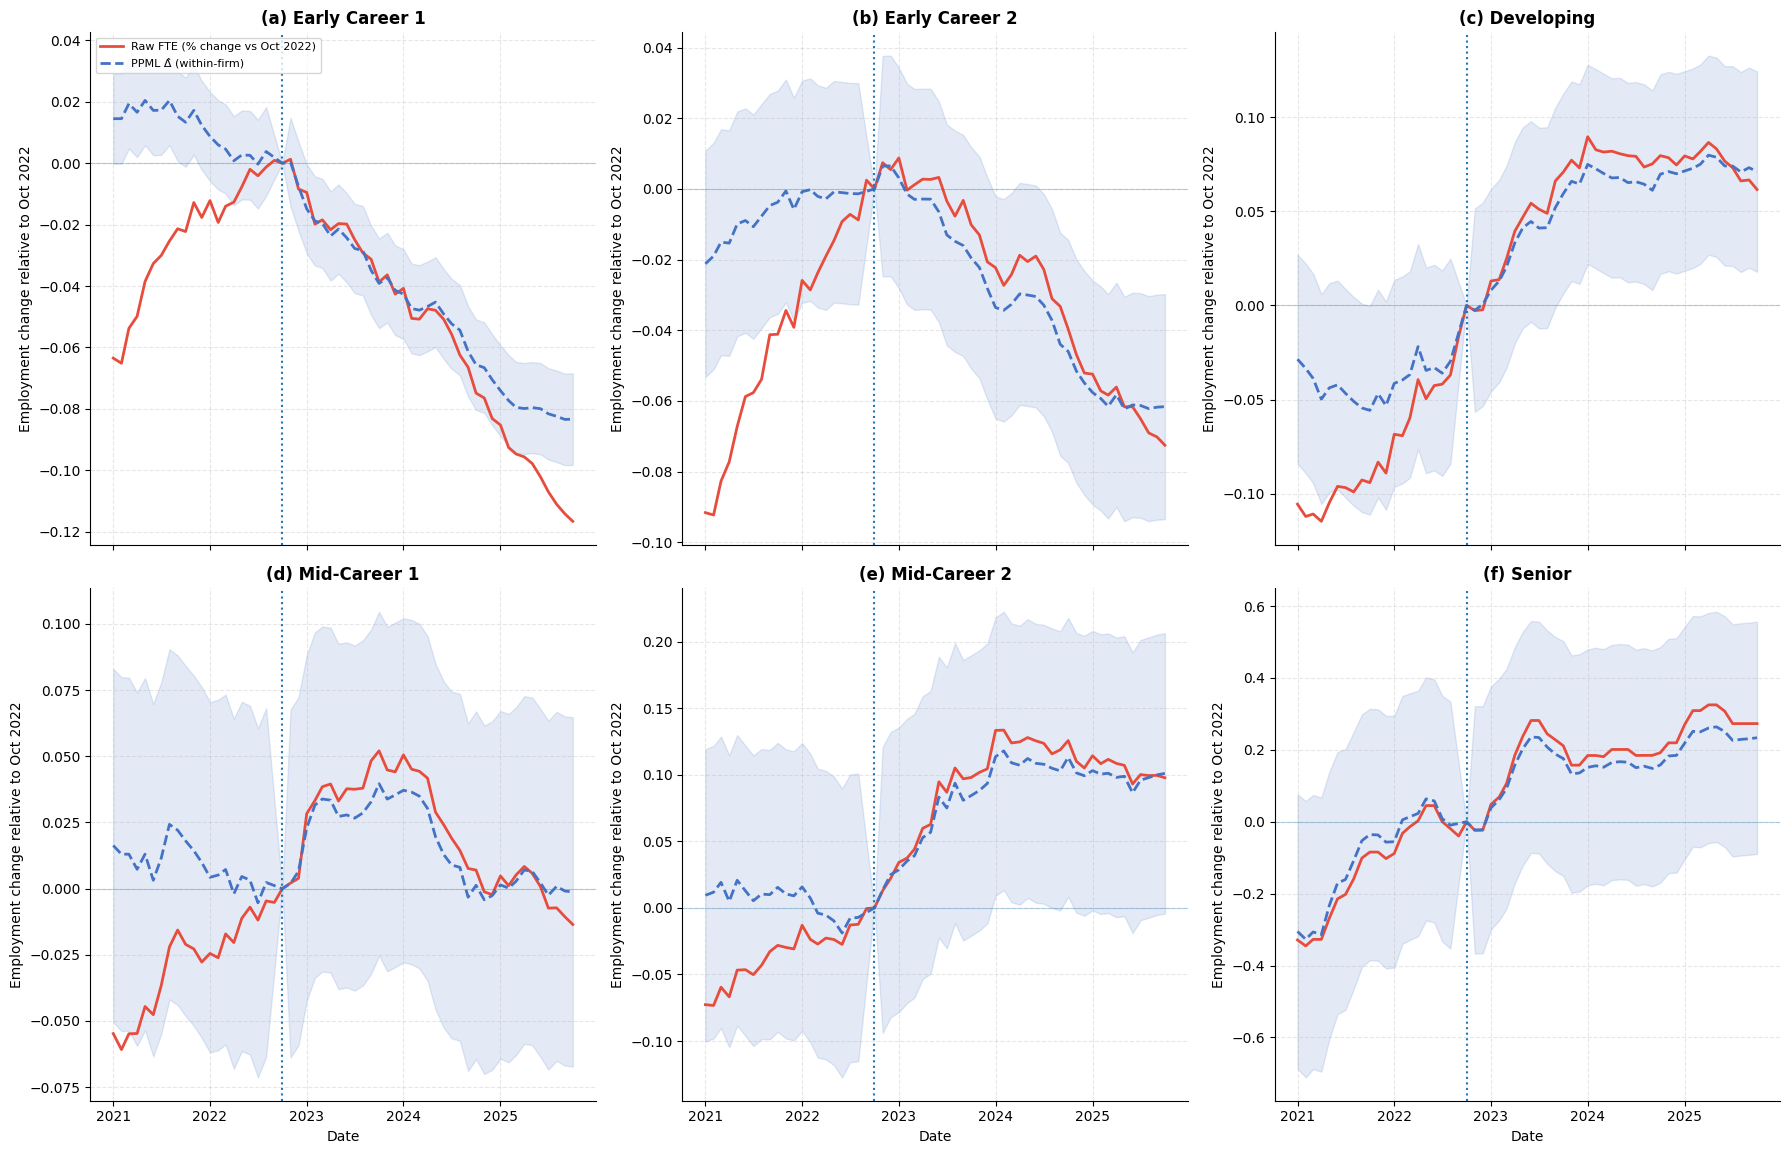

: 

In [ ]:
# =============================================================================
# EXAMPLE: PLOT OCCUPATION WITH DYNAMIC FILE NAMING
# =============================================================================

# Example occupation to plot
example_occupation_code = "43-4051.00"

# Dynamic filename based on N_FIRMS configuration
if N_FIRMS is None:
    plot_filename = f"R_ALL_EU_occupation_{example_occupation_code}.pdf"
else:
    plot_filename = f"R_{N_FIRMS}_EU_occupation_{example_occupation_code}.pdf"

plot_save_path = os.path.join(notebook_dir, "Images", plot_filename)

plot_occupation_event_study(
    occupation_code=example_occupation_code,
    occupation_panel=occupation_panel,
    occupation_results=occupation_results,
    occupation_summary=occupation_summary,
    baseline_date=pd.Timestamp("2022-10-01"),
    force_full_raw_series=True,
    save_path=plot_save_path
)